In [1]:
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
import tensorflow.compat.v1 as tf
from scipy.ndimage.interpolation import rotate
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Mounting the Google Drive for loadring the files (if you are using your local machine, don't run the cell below)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading datas

In [27]:
train_data_dir = r'/content/drive/My Drive/Courses/DeepLearning/HW01/Q1_train.csv'
test_data_dir = r'/content/drive/My Drive/Courses/DeepLearning/HW01/Q1_test.csv'
data_train = []
data_test = []
with open(train_data_dir, 'r') as csvfile:
  csvreader = csv.reader(csvfile)
  for row in csvreader:
      data_train.append(row)
with open(test_data_dir, 'r') as csvfile:
  csvreader = csv.reader(csvfile)
  for row in csvreader:
      data_test.append(row)

data_train = np.array(data_train[1:], dtype=np.float32)
data_test = np.array(data_test[1:], dtype=np.float32)

In [28]:
num_of_train_samples = len(data_train[:, 1])
validation_set_size = 0.7

x_train = data_train[0:int(validation_set_size*num_of_train_samples), 1:]
y_train_cls = data_train[0:int(validation_set_size*num_of_train_samples), 0]

for i in range(len(y_train_cls)):
  if y_train_cls[i]>=9:
    y_train_cls[i] = y_train_cls[i]-1

x_validation = data_train[int(validation_set_size*num_of_train_samples)+1:, 1:]
y_validation_cls = data_train[int(validation_set_size*num_of_train_samples)+1:, 0]

for i in range(len(y_validation_cls)):
  if y_validation_cls[i]>=9:
    y_validation_cls[i] = y_validation_cls[i]-1


x_test = data_test[:,1:]
y_test_cls = data_test[:,0]

for i in range(len(y_test_cls)):
  if y_test_cls[i]>=9:
    y_test_cls[i] = y_test_cls[i]-1

img_size_flat = len(x_train[0])
img_shape = (int(np.sqrt(img_size_flat)), int(np.sqrt(img_size_flat)))
alphabets =  'ABCDEFGHIKLMNOPQRSTUVWXY'
num_classes = len(alphabets)

# normalization
x_train = x_train/255
x_test = x_test/255
x_validation = x_validation/255

In [29]:
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train_cls.reshape(-1, 1)).toarray()
y_test = enc.fit_transform(y_test_cls.reshape(-1, 1)).toarray()
y_validation = enc.fit_transform(y_validation_cls.reshape(-1, 1)).toarray()

## Part a - showing some of the the images

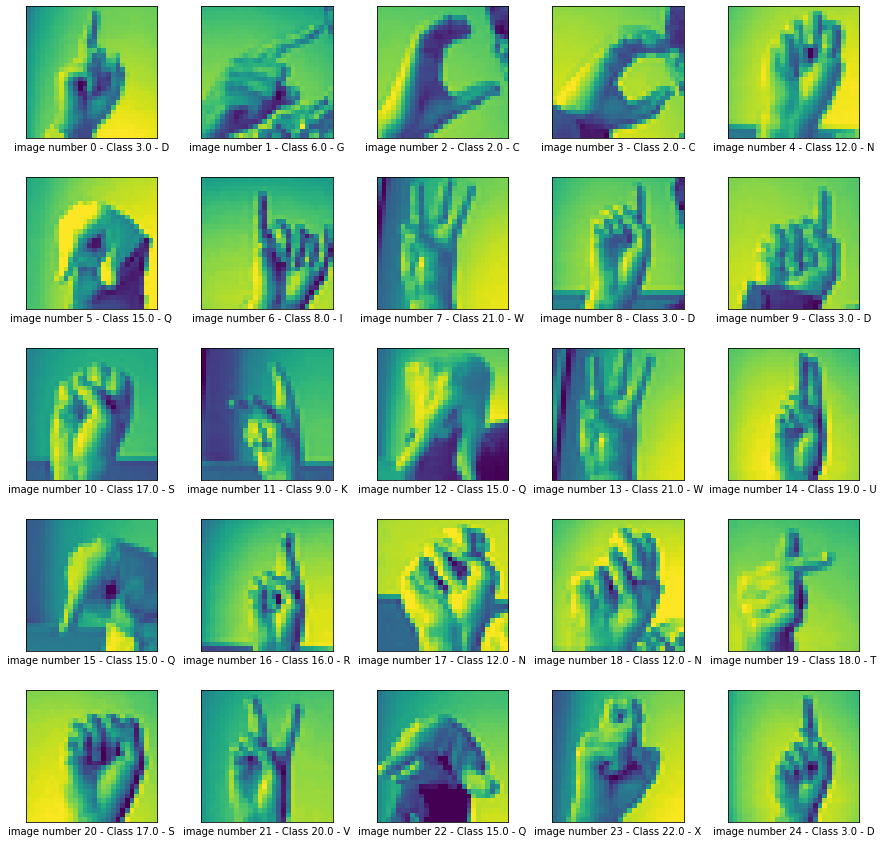

In [17]:
fig, axes = plt.subplots(5, 5, figsize=(15,15))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, ax in enumerate(axes.flat):
    image = x_train[i].reshape(img_shape)
    # Set the label for the sub-plot.
    ax.set_xlabel("image number {0} - Class {1} - {2}".format(i, y_train_cls[i], alphabets[int(y_train_cls[i])]))
    # Plot the image.
    ax.imshow(image)
    # Remove ticks from each sub-plot.
    ax.set_xticks([])
    ax.set_yticks([])

## Part b - Designing an MLP

#### SGD 

##### Network graph

In [108]:
tf.reset_default_graph()

learning_rate = 0.01

# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')
# network weights
weights_out = tf.Variable(tf.random_normal([img_size_flat, num_classes],mean=0,stddev=1/np.sqrt(img_size_flat)))
# network biases
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))


y_pred = tf.matmul(x, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred)
y_pred_cls = tf.argmax(y_pred_act, axis=1)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
cost = tf.reduce_mean(loss)

optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate, name='SGD').minimize(cost)

# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb]}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb]}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls}

##### Helper Functions

In [16]:
def optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation):
    accs_train = np.zeros([num_epochs])
    accs_validation = np.zeros([num_epochs])
    accs_test = np.zeros([num_epochs])
    loss = np.zeros([num_epochs])
    x_train = feed_dict_train[x]
    y_train = feed_dict_train[y_true]
    [Test_Accuracy, Loss] = calcAccuracy(feed_dict_test)
    [Train_Accuracy, _] = calcAccuracy(feed_dict_train)
    [Valid_Accuracy, _] = calcAccuracy(feed_dict_validation)
    print('\n ====== Epoch 0 ====== ')
    print("Training Acc = {0:.2f} - Validation Acc = {1:.2f} - Test Acc = {2:.2f} - Loss = {3:.4f}\n".format(Train_Accuracy, Valid_Accuracy, Test_Accuracy, Loss) , sep=' ', end='', flush=False)
    for epoch in range(0,num_epochs):
        
      list_of_samples = [i for i in range(0, x_train.shape[0])]
      for i in range(int(x_train.shape[0]/batch_size)):
          if len(list_of_samples) < batch_size:
            list_of_samples = [i for i in range(0, x_train.shape[0])]
          indexes = random.sample(list_of_samples, batch_size)
          for j in indexes:
            list_of_samples.remove(j)
          x_batch = x_train[indexes, :]
          y_true_batch = y_train[indexes]
          feed_dict = {x: x_batch, y_true: y_true_batch}
          session.run(optimizer, feed_dict=feed_dict)
      if np.mod(epoch,10)==1:
        print('\n ====== Epoch {0} ====== '.format(epoch))
        [Test_Accuracy, Loss] = calcAccuracy(feed_dict_test)
        [Train_Accuracy, _] = calcAccuracy(feed_dict_train)
        [Valid_Accuracy, _] = calcAccuracy(feed_dict_validation)
        print("Training Acc = {0:.2f} - Validation Acc = {1:.2f} - Test Acc = {2:.2f} - Loss = {3:.4f}\n".format(Train_Accuracy, Valid_Accuracy, Test_Accuracy, Loss) , sep=' ', end='', flush=False)
      [accs_train[epoch], loss[epoch]]= calcAccuracy(feed_dict_train)
      [accs_validation[epoch], _]= calcAccuracy(feed_dict_validation)
      [accs_test[epoch], _] = calcAccuracy(feed_dict_test)
    return accs_train, accs_validation, accs_test, loss

def calcAccuracy(feed_dict):
    acc, loss = session.run([accuracy, cost], feed_dict=feed_dict)
    return acc, loss

def plot_weights(weights):
    w = session.run(weights)
    w_min = -1
    w_max = 1
    fig, axes = plt.subplots(1, 1, figsize=(5,5))
    axes.imshow(np.uint8(abs(w)), vmin=w_min, vmax=w_max, cmap='seismic')
    axes.set_xticks([])
    axes.set_yticks([])
    plt.show()

def print_confusion_matrix():
    cls_true = feed_dict_train[y_true_cls]
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_train)
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

##### Runing Optimization


 ====== Epoch 0 ====== 
Training Acc = 0.04 - Validation Acc = 0.04 - Test Acc = 0.04 - Loss = 3.4412

 ====== Epoch 1 ====== 
Training Acc = 0.38 - Validation Acc = 0.39 - Test Acc = 0.35 - Loss = 2.6459

 ====== Epoch 11 ====== 
Training Acc = 0.66 - Validation Acc = 0.66 - Test Acc = 0.55 - Loss = 1.7839

 ====== Epoch 21 ====== 
Training Acc = 0.72 - Validation Acc = 0.71 - Test Acc = 0.58 - Loss = 1.5417

 ====== Epoch 31 ====== 
Training Acc = 0.76 - Validation Acc = 0.74 - Test Acc = 0.61 - Loss = 1.4089

 ====== Epoch 41 ====== 
Training Acc = 0.79 - Validation Acc = 0.78 - Test Acc = 0.63 - Loss = 1.3351

 ====== Epoch 51 ====== 
Training Acc = 0.80 - Validation Acc = 0.79 - Test Acc = 0.66 - Loss = 1.2597

 ====== Epoch 61 ====== 
Training Acc = 0.83 - Validation Acc = 0.82 - Test Acc = 0.66 - Loss = 1.2189

 ====== Epoch 71 ====== 
Training Acc = 0.84 - Validation Acc = 0.83 - Test Acc = 0.66 - Loss = 1.1874

 ====== Epoch 81 ====== 
Training Acc = 0.84 - Validation Acc = 0

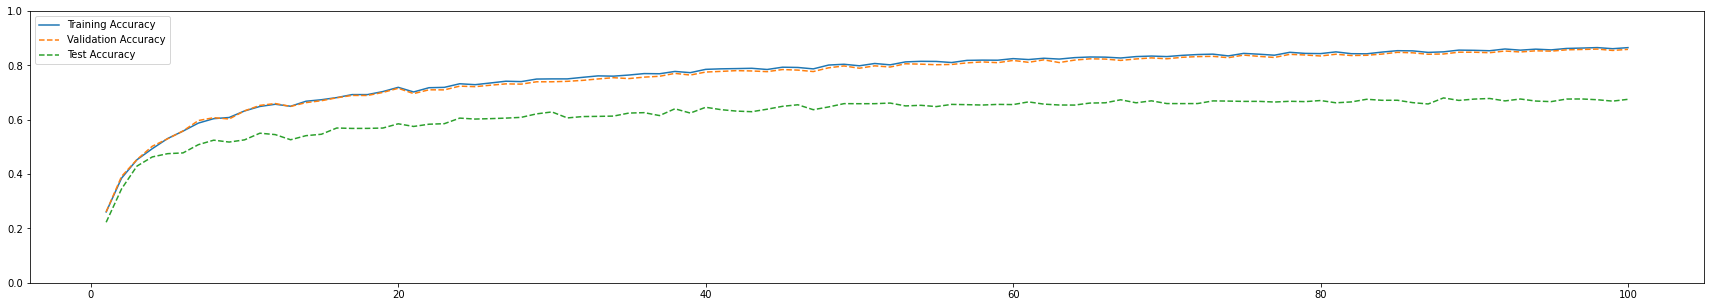

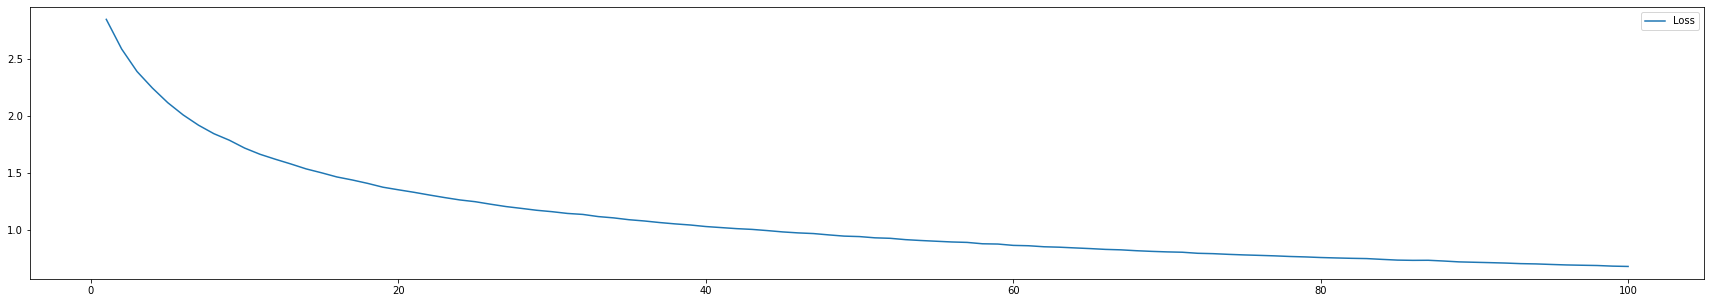

In [110]:
# print_confusion_matrix()
num_epochs = 100
batch_size = 64
[accs_train, accs_validation, accs_test, loss] = optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_validation, '--', label='Validation Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_test, '--', label='Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), loss, label='Loss')
plt.legend()
plt.show()

# print_confusion_matrix()

#### ADAM

##### Network graph

In [115]:
tf.reset_default_graph()

learning_rate = 3e-4
beta1 = 0.85
beta2 = 0.999
# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights_out = tf.Variable(tf.random_normal([img_size_flat, num_classes],mean=0,stddev=1/np.sqrt(img_size_flat)))
# network biases
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

y_pred = tf.matmul(x, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred)
y_pred_cls = tf.argmax(y_pred_act, axis=1)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
cost = tf.reduce_mean(loss)

optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=1e-08, name='ADAM').minimize(cost)

# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb]}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb]}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls}

##### Runing Optimization


 ====== Epoch 0 ====== 
Training Acc = 0.04 - Validation Acc = 0.03 - Test Acc = 0.07 - Loss = 3.4218

 ====== Epoch 1 ====== 
Training Acc = 0.46 - Validation Acc = 0.47 - Test Acc = 0.43 - Loss = 2.3335

 ====== Epoch 11 ====== 
Training Acc = 0.71 - Validation Acc = 0.71 - Test Acc = 0.61 - Loss = 1.4722

 ====== Epoch 21 ====== 
Training Acc = 0.79 - Validation Acc = 0.78 - Test Acc = 0.64 - Loss = 1.2774

 ====== Epoch 31 ====== 
Training Acc = 0.84 - Validation Acc = 0.84 - Test Acc = 0.66 - Loss = 1.1658

 ====== Epoch 41 ====== 
Training Acc = 0.86 - Validation Acc = 0.86 - Test Acc = 0.66 - Loss = 1.1252

 ====== Epoch 51 ====== 
Training Acc = 0.89 - Validation Acc = 0.89 - Test Acc = 0.68 - Loss = 1.0615

 ====== Epoch 61 ====== 
Training Acc = 0.91 - Validation Acc = 0.90 - Test Acc = 0.69 - Loss = 1.0386

 ====== Epoch 71 ====== 
Training Acc = 0.92 - Validation Acc = 0.92 - Test Acc = 0.70 - Loss = 1.0116

 ====== Epoch 81 ====== 
Training Acc = 0.94 - Validation Acc = 0

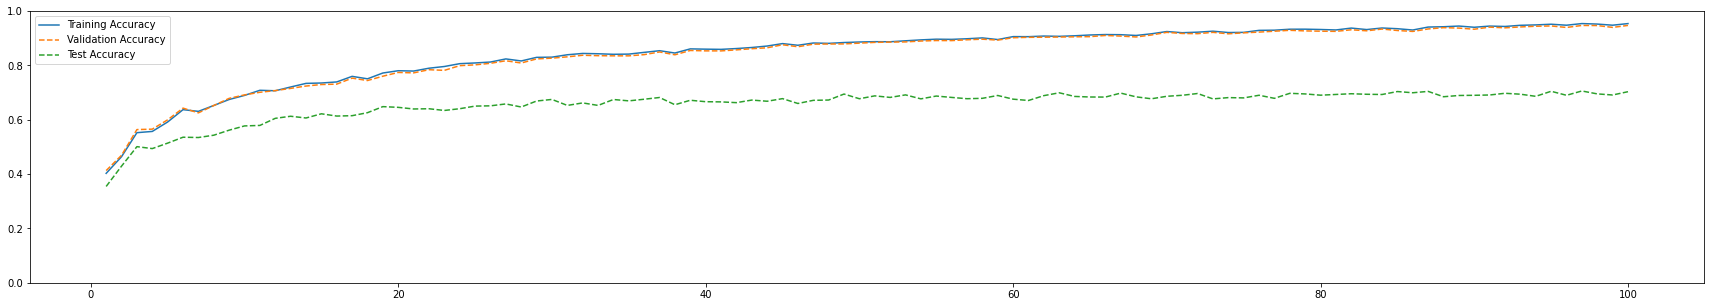

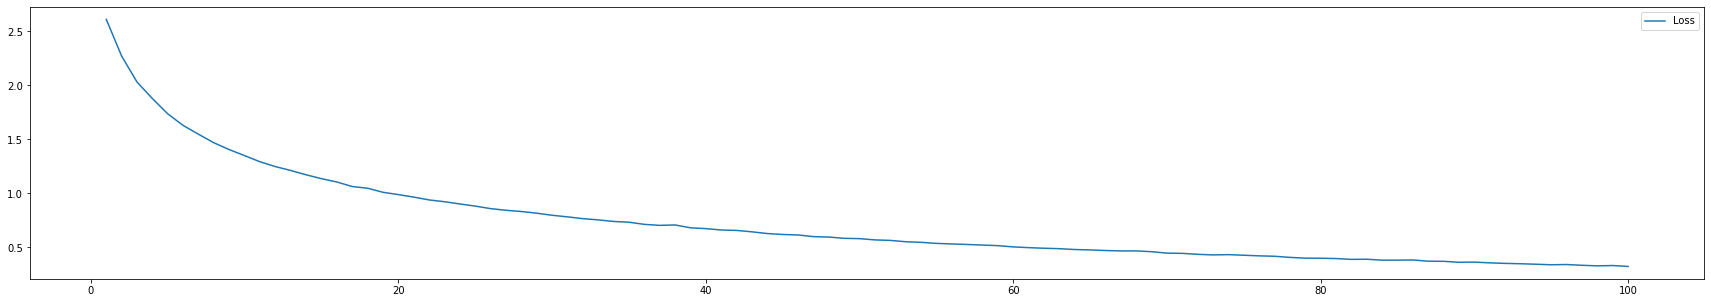

In [116]:
# print_confusion_matrix()
num_epochs = 100
batch_size = 64
[accs_train, accs_validation, accs_test, loss] = optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_validation, '--', label='Validation Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_test, '--', label='Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), loss, label='Loss')
plt.legend()
plt.show()

# print_confusion_matrix()

## Part c

## Part d - Adding Dropout

#### SGD 

##### Network graph

In [124]:
tf.reset_default_graph()

learning_rate = 0.5

# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights_out = tf.Variable(tf.random_normal([img_size_flat, num_classes],mean=0,stddev=1/np.sqrt(img_size_flat)))
# network biases
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

keep_prob = tf.placeholder(tf.float32)

y_pred = tf.matmul(x, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred)
y_pred_act_DO = tf.compat.v1.layers.dropout(y_pred_act)
y_pred_cls = tf.argmax(y_pred_act_DO, axis=1)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
# loss = tf.compat.v1.losses.mean_squared_error(y_true, y_pred)
cost = tf.reduce_mean(loss)

optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate, name='SGD').minimize(cost)

# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb],
                   keep_prob:1}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb],
                   keep_prob:0.5}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls,
                   keep_prob:1}

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:393: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  warnings.warn('`tf.layers.dropout` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


##### Helper Functions

In [12]:
def optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation):
    accs_train = np.zeros([num_epochs])
    accs_validation = np.zeros([num_epochs])
    accs_test = np.zeros([num_epochs])
    loss = np.zeros([num_epochs])
    x_train = feed_dict_train[x]
    y_train = feed_dict_train[y_true]
    [Test_Accuracy, _] = calcAccuracy(feed_dict_test)
    [Train_Accuracy, Loss] = calcAccuracy(feed_dict_train)
    [Valid_Accuracy, _] = calcAccuracy(feed_dict_validation)
    print('\n ====== Epoch 0 ====== ')
    print("Training Acc = {0:.2f} - Validation Acc = {1:.2f} - Test Acc = {2:.2f} - Loss = {3:.4f}\n".format(Train_Accuracy, Valid_Accuracy, Test_Accuracy, Loss) , sep=' ', end='', flush=False)
    for epoch in range(0,num_epochs):
        
      list_of_samples = [i for i in range(0, x_train.shape[0])]
      for i in range(int(x_train.shape[0]/batch_size)):
          if len(list_of_samples) < batch_size:
            list_of_samples = [i for i in range(0, x_train.shape[0])]
          indexes = random.sample(list_of_samples, batch_size)
          for j in indexes:
            list_of_samples.remove(j)
          x_batch = x_train[indexes, :]
          y_true_batch = y_train[indexes]
          feed_dict = {x: x_batch, y_true: y_true_batch, keep_prob:feed_dict_train[keep_prob]}
          session.run(optimizer, feed_dict=feed_dict)
      if np.mod(epoch,10)==1:
        print('\n ====== Epoch {0} ====== '.format(epoch))
        [Test_Accuracy, _] = calcAccuracy(feed_dict_test)
        [Train_Accuracy, Loss] = calcAccuracy(feed_dict_train)
        [Valid_Accuracy, _] = calcAccuracy(feed_dict_validation)
        print("Training Acc = {0:.2f} - Validation Acc = {1:.2f} - Test Acc = {2:.2f} - Loss = {3:.4f}\n".format(Train_Accuracy, Valid_Accuracy, Test_Accuracy, Loss) , sep=' ', end='', flush=False)
      [accs_train[epoch], loss[epoch]]= calcAccuracy(feed_dict_train)
      [accs_validation[epoch], _]= calcAccuracy(feed_dict_validation)
      [accs_test[epoch], _] = calcAccuracy(feed_dict_test)
    return accs_train, accs_validation, accs_test, loss

##### Runing Optimization


 ====== Epoch 0 ====== 
Training Acc = 0.04 - Validation Acc = 0.04 - Test Acc = 0.04 - Loss = 3.2938

 ====== Epoch 1 ====== 
Training Acc = 0.49 - Validation Acc = 0.49 - Test Acc = 0.44 - Loss = 5.0764

 ====== Epoch 11 ====== 
Training Acc = 0.84 - Validation Acc = 0.82 - Test Acc = 0.56 - Loss = 1.2117

 ====== Epoch 21 ====== 
Training Acc = 0.97 - Validation Acc = 0.97 - Test Acc = 0.68 - Loss = 0.1029

 ====== Epoch 31 ====== 
Training Acc = 1.00 - Validation Acc = 0.99 - Test Acc = 0.68 - Loss = 0.0466

 ====== Epoch 41 ====== 
Training Acc = 1.00 - Validation Acc = 1.00 - Test Acc = 0.69 - Loss = 0.0291


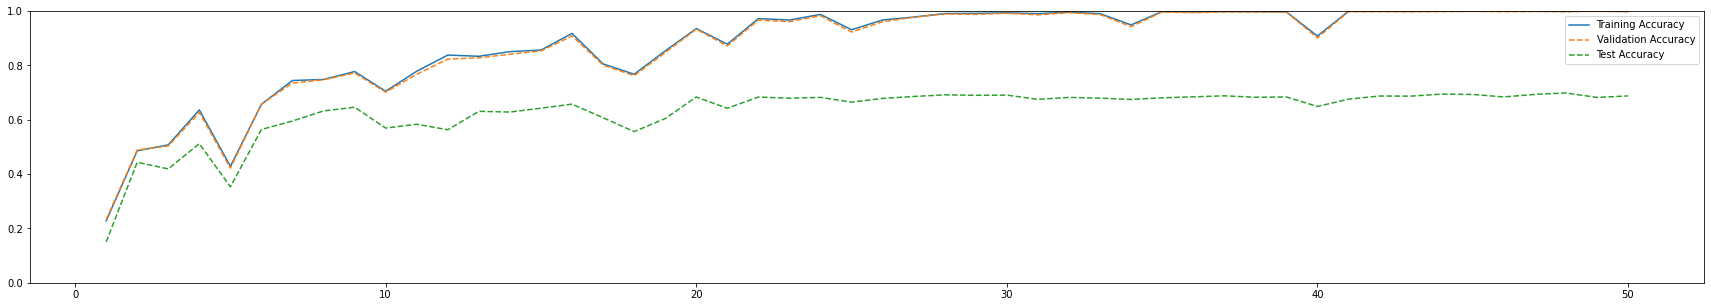

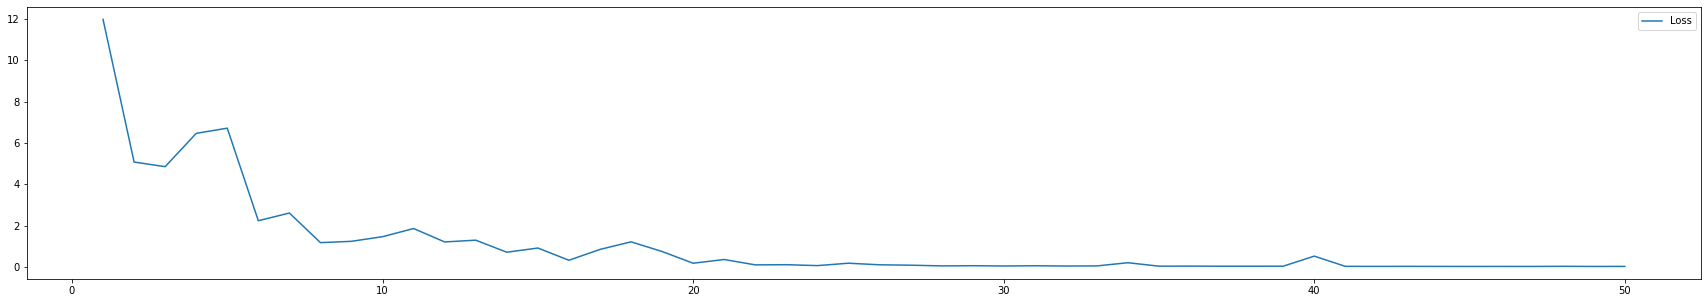

In [126]:
# print_confusion_matrix()
num_epochs = 50
batch_size = 64
[accs_train, accs_validation, accs_test, loss] = optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_validation, '--', label='Validation Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_test, '--', label='Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), loss, label='Loss')
plt.legend()
plt.show()

# print_confusion_matrix()

In [ ]:
Test_Accuracy = session.run(accuracy, feed_dict=feed_dict_test)
print(Test_Accuracy)

0.6683866


## Part e - Adding more layers

#### SGD

##### Network graph

In [129]:
tf.reset_default_graph()

learning_rate = 0.1
batch_size = 64

hl1_n = int(2*img_size_flat)
hl2_n = int(img_size_flat)

# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights_1 = tf.Variable(tf.random_normal([img_size_flat, hl1_n],mean=0,stddev=1/np.sqrt(img_size_flat)))
weights_2 = tf.Variable(tf.random_normal([hl1_n, hl2_n],mean=0,stddev=1/np.sqrt(hl1_n)))
weights_out = tf.Variable(tf.random_normal([hl2_n, num_classes],mean=0,stddev=1/np.sqrt(hl2_n)))
# network biases
biases_1 = tf.Variable(tf.random_normal([hl1_n],mean=0,stddev=1/np.sqrt(hl1_n)))
biases_2 = tf.Variable(tf.random_normal([hl2_n],mean=0,stddev=1/np.sqrt(hl2_n)))
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

keep_prob = tf.placeholder(tf.float32)


y_1 = tf.matmul(x, weights_1) + biases_1
y_1_act = tf.nn.sigmoid(y_1)
y_1_act_DO = tf.compat.v1.layers.dropout(y_1_act)
y_1_act_DO_BN = tf.compat.v1.layers.batch_normalization(y_1_act_DO)

y_2 = tf.matmul(y_1_act_DO_BN, weights_2) + biases_2
y_2_act = tf.nn.sigmoid(y_2)
y_2_act_DO = tf.compat.v1.layers.dropout(y_2_act)
y_2_act_DO_BN = tf.compat.v1.layers.batch_normalization(y_2_act_DO)

y_pred = tf.matmul(y_2_act_DO_BN, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred)
y_pred_act_DO = tf.compat.v1.layers.dropout(y_pred_act, name="Y_PRED")
y_pred_act_DO_BN = tf.compat.v1.layers.dropout(y_pred_act, name="Y_PRED")
y_pred_cls = tf.argmax(y_pred_act_DO_BN, axis=1, name="Y_PRED_CLS")

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
# loss = tf.compat.v1.losses.mean_squared_error(y_true, y_pred)
cost = tf.reduce_mean(loss)

optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate, name='SGD').minimize(cost)

# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb]}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb],
                   keep_prob:0.5}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls}


/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:393: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  warnings.warn('`tf.layers.dropout` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:424: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalization` is deprecated and '


##### Runing Optimization


 ====== Epoch 0 ====== 
Training Acc = 0.04 - Validation Acc = 0.04 - Test Acc = 0.05 - Loss = 3.2818

 ====== Epoch 1 ====== 
Training Acc = 0.07 - Validation Acc = 0.07 - Test Acc = 0.05 - Loss = 3.0521

 ====== Epoch 11 ====== 
Training Acc = 0.59 - Validation Acc = 0.58 - Test Acc = 0.52 - Loss = 1.2243

 ====== Epoch 21 ====== 
Training Acc = 0.75 - Validation Acc = 0.74 - Test Acc = 0.61 - Loss = 0.7558

 ====== Epoch 31 ====== 
Training Acc = 0.87 - Validation Acc = 0.86 - Test Acc = 0.67 - Loss = 0.4040

 ====== Epoch 41 ====== 
Training Acc = 0.97 - Validation Acc = 0.97 - Test Acc = 0.74 - Loss = 0.1403


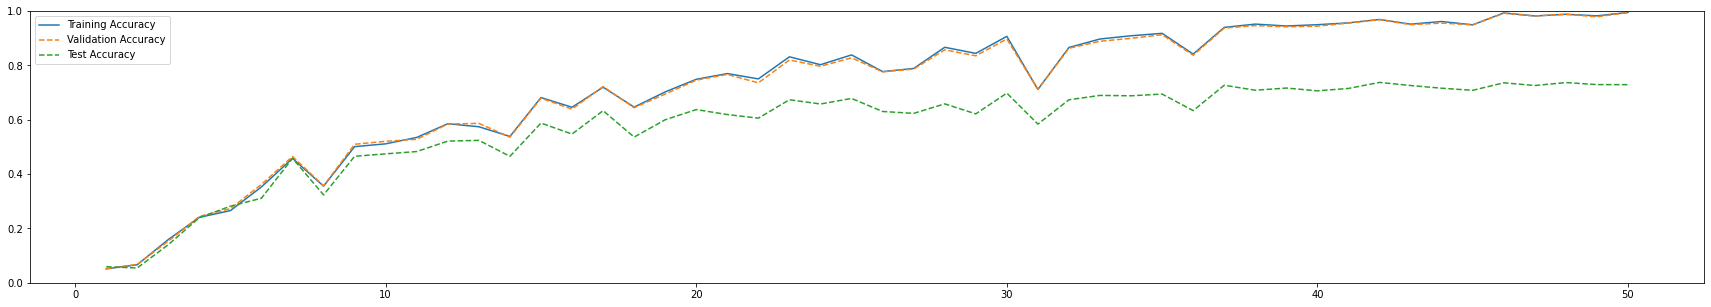

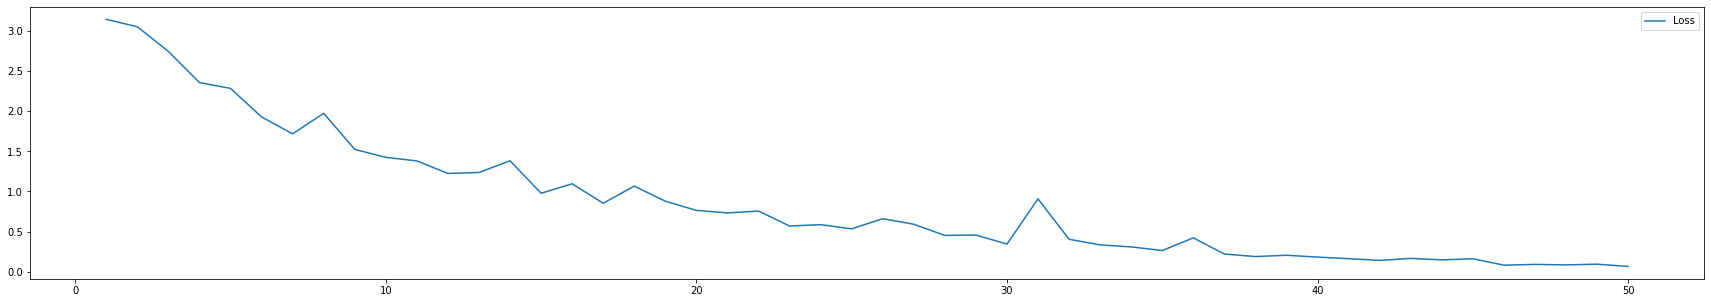

In [130]:
# print_confusion_matrix()
num_epochs = 50
batch_size = 64
[accs_train, accs_validation, accs_test, loss] = optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_validation, '--', label='Validation Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_test, '--', label='Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), loss, label='Loss')
plt.legend()
plt.show()

# print_confusion_matrix()

#### ADAM

##### Network graph

In [83]:
tf.reset_default_graph()
beta1 = 0.9
beta2 = 0.999
learning_rate = 3e-4

hl1_n = int(512)
hl2_n = int(128)

# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights_1 = tf.Variable(tf.random_normal([img_size_flat, hl1_n],mean=0,stddev=1/np.sqrt(img_size_flat)))
weights_2 = tf.Variable(tf.random_normal([hl1_n, hl2_n],mean=0,stddev=1/np.sqrt(hl1_n)))
weights_out = tf.Variable(tf.random_normal([hl2_n, num_classes],mean=0,stddev=1/np.sqrt(hl2_n)))
# network biases
biases_1 = tf.Variable(tf.random_normal([hl1_n],mean=0,stddev=1/np.sqrt(hl1_n)))
biases_2 = tf.Variable(tf.random_normal([hl2_n],mean=0,stddev=1/np.sqrt(hl2_n)))
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

keep_prob = tf.placeholder(tf.float32)


y_1 = tf.matmul(x, weights_1) + biases_1
y_1_act = tf.nn.relu(y_1)
y_1_act_DO = tf.compat.v1.layers.dropout(y_1_act, rate=keep_prob)
y_1_act_DO_BN = tf.compat.v1.layers.batch_normalization(y_1_act_DO)

y_2 = tf.matmul(y_1_act_DO_BN, weights_2) + biases_2
y_2_act = tf.nn.relu(y_2)
y_2_act_DO = tf.compat.v1.layers.dropout(y_2_act, rate=keep_prob)
y_2_act_DO_BN = tf.compat.v1.layers.batch_normalization(y_2_act_DO)

y_pred = tf.matmul(y_2_act_DO_BN, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred, name="Y_PRED")
y_pred_cls = tf.argmax(y_pred_act, axis=1, name="Y_PRED_CLS")

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
cost = tf.reduce_mean(loss)

optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=1e-08, name='ADAM').minimize(cost)
# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb],
                  keep_prob:1}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb],
                   keep_prob:0.5}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls,
                  keep_prob:1}

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:393: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  warnings.warn('`tf.layers.dropout` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:424: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalization` is deprecated and '


##### Helper Functions

In [17]:
def optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation, update_freq):
    accs_train = np.zeros([num_epochs])
    accs_validation = np.zeros([num_epochs])
    accs_test = np.zeros([num_epochs])
    loss = np.zeros([num_epochs])
    x_train = feed_dict_train[x]
    y_train = feed_dict_train[y_true]
    [Test_Accuracy, _] = calcAccuracy(feed_dict_test)
    [Train_Accuracy, Loss] = calcAccuracy(feed_dict_train)
    [Valid_Accuracy, _] = calcAccuracy(feed_dict_validation)
    print('\n ====== Epoch 0 ====== ')
    print("Training Acc = {0:.2f} - Validation Acc = {1:.2f} - Test Acc = {2:.2f} - Loss = {3:.4f}\n".format(Train_Accuracy, Valid_Accuracy, Test_Accuracy, Loss) , sep=' ', end='', flush=False)
    for epoch in range(0,num_epochs):
        
      list_of_samples = [i for i in range(0, x_train.shape[0])]
      for i in range(int(x_train.shape[0]/batch_size)):
          if len(list_of_samples) < batch_size:
            list_of_samples = [i for i in range(0, x_train.shape[0])]
          indexes = random.sample(list_of_samples, batch_size)
          for j in indexes:
            list_of_samples.remove(j)
          x_batch = x_train[indexes, :]
          y_true_batch = y_train[indexes]
          feed_dict = {x: x_batch, y_true: y_true_batch, keep_prob:feed_dict_train[keep_prob]}
          session.run(optimizer, feed_dict=feed_dict)
      if np.mod(epoch,update_freq)==1:
        print('\n ====== Epoch {0} ====== '.format(epoch))
        [Test_Accuracy, _] = calcAccuracy(feed_dict_test)
        [Train_Accuracy, Loss] = calcAccuracy(feed_dict_train)
        [Valid_Accuracy, _] = calcAccuracy(feed_dict_validation)
        print("Training Acc = {0:.2f} - Validation Acc = {1:.2f} - Test Acc = {2:.2f} - Loss = {3:.4f}\n".format(Train_Accuracy, Valid_Accuracy, Test_Accuracy, Loss) , sep=' ', end='', flush=False)
      [accs_train[epoch], loss[epoch]]= calcAccuracy(feed_dict_train)
      [accs_validation[epoch], _]= calcAccuracy(feed_dict_validation)
      [accs_test[epoch], _] = calcAccuracy(feed_dict_test)
    return accs_train, accs_validation, accs_test, loss

##### Runing Optimization


 ====== Epoch 0 ====== 
Training Acc = 0.04 - Validation Acc = 0.04 - Test Acc = 0.03 - Loss = 3.2366

 ====== Epoch 1 ====== 
Training Acc = 0.60 - Validation Acc = 0.60 - Test Acc = 0.53 - Loss = 1.3349

 ====== Epoch 3 ====== 
Training Acc = 0.79 - Validation Acc = 0.79 - Test Acc = 0.64 - Loss = 0.7796

 ====== Epoch 5 ====== 
Training Acc = 0.80 - Validation Acc = 0.79 - Test Acc = 0.65 - Loss = 0.6280

 ====== Epoch 7 ====== 
Training Acc = 0.92 - Validation Acc = 0.91 - Test Acc = 0.72 - Loss = 0.3553

 ====== Epoch 9 ====== 
Training Acc = 0.95 - Validation Acc = 0.95 - Test Acc = 0.74 - Loss = 0.2345

 ====== Epoch 11 ====== 
Training Acc = 0.98 - Validation Acc = 0.98 - Test Acc = 0.74 - Loss = 0.1429

 ====== Epoch 13 ====== 
Training Acc = 0.98 - Validation Acc = 0.97 - Test Acc = 0.73 - Loss = 0.1199

 ====== Epoch 15 ====== 
Training Acc = 0.99 - Validation Acc = 0.99 - Test Acc = 0.74 - Loss = 0.0654

 ====== Epoch 17 ====== 
Training Acc = 1.00 - Validation Acc = 1.00 

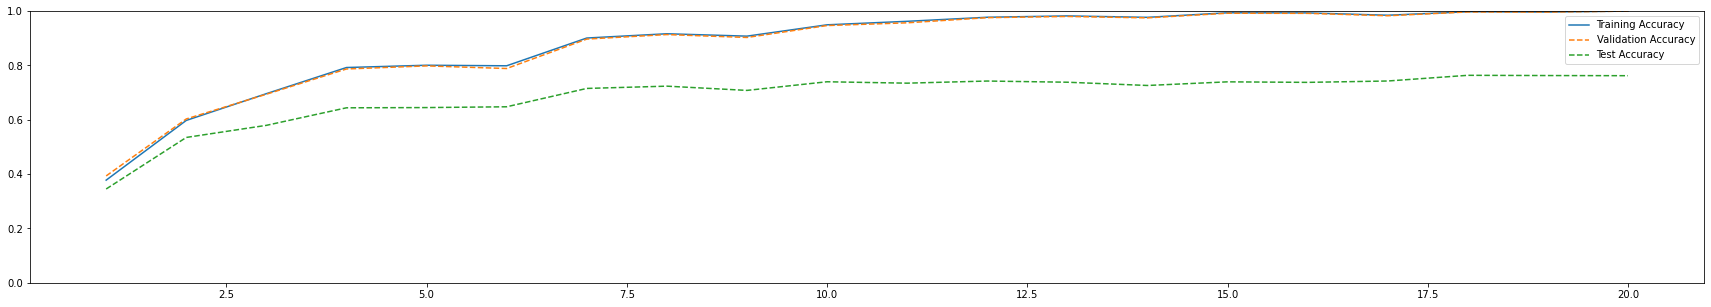

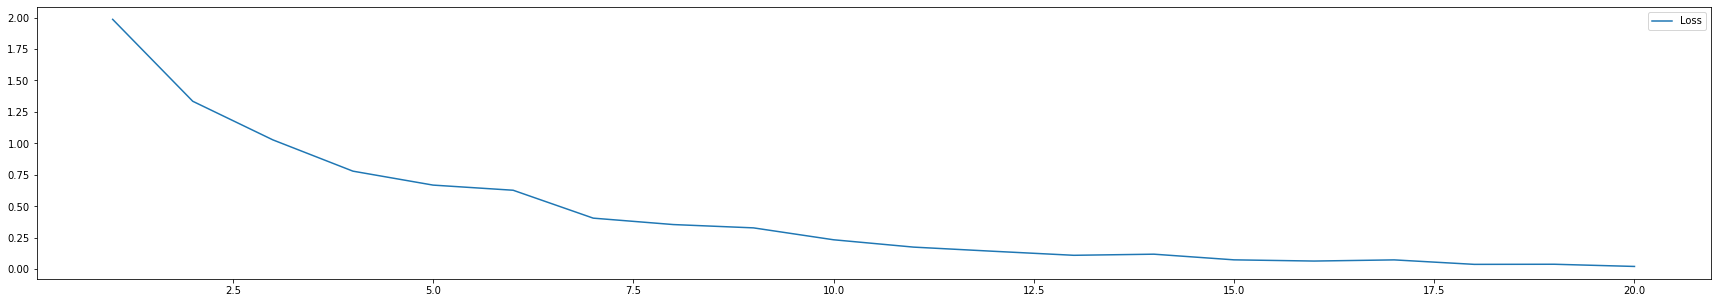

In [86]:
# print_confusion_matrix()
num_epochs = 20
batch_size = 64
update_freq = 2
[accs_train, accs_validation, accs_test, loss] = optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation, update_freq = update_freq)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_validation, '--', label='Validation Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_test, '--', label='Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), loss, label='Loss')
plt.legend()
plt.show()

# print_confusion_matrix()

#### Exporting the Trained model

In [ ]:
saver = tf.train.Saver()
saver.save(session, '/content/drive/My Drive/Courses/DeepLearning/Sign_Detector_78pAcc')

'/content/drive/My Drive/Courses/DeepLearning/Sign_Detector_78pAcc'

## Extra Works - Adding Rotated Images to the Training Set

I rotated all the images in the training set by +5 and -5 degrees for better performance

##### Extending the Training Set

In [30]:
dataset_size = np.shape(x_train)[0]
np.append([[1, 2, 3], [4, 5, 6]], [[7, 8, 9]], axis=0)
print(np.shape(x_train))
print(np.shape(y_train_cls))
list_of_samples = [i for i in range(0, x_train.shape[0])]
indexes = random.sample(list_of_samples, 4000)
for angle in [10,20]:
  for i in indexes:
    image = x_train[i,:]
    rotated_pos = rotate(np.reshape(image, img_shape), angle=angle, reshape=False)
    rotated_neg = rotate(np.reshape(image, img_shape), angle=-1*angle, reshape=False)
    rotated_pos = np.reshape(rotated_pos, (1,img_size_flat))
    rotated_neg = np.reshape(rotated_neg, (1,img_size_flat))
    x_train = np.append(x_train, rotated_pos, axis=0)
    x_train = np.append(x_train, rotated_neg, axis=0)
    y_train_cls = np.append(y_train_cls, y_train_cls[i])
    y_train_cls = np.append(y_train_cls, y_train_cls[i])
print(np.shape(x_train))
print(np.shape(y_train_cls))

enc = OneHotEncoder()
y_train = enc.fit_transform(y_train_cls.reshape(-1, 1)).toarray()

(19218, 784)
(19218,)
(35218, 784)
(35218,)


##### Network graph

In [38]:
tf.reset_default_graph()
beta1 = 0.9
beta2 = 0.999
learning_rate = 3e-4

hl1_n = int(2*784)
hl2_n = int(784)
hl3_n = int(256)

# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights_1 = tf.Variable(tf.random_normal([img_size_flat, hl1_n],mean=0,stddev=1/np.sqrt(img_size_flat)))
weights_2 = tf.Variable(tf.random_normal([hl1_n, hl2_n],mean=0,stddev=1/np.sqrt(hl1_n)))
weights_3 = tf.Variable(tf.random_normal([hl2_n, hl3_n],mean=0,stddev=1/np.sqrt(hl2_n)))
weights_out = tf.Variable(tf.random_normal([hl3_n, num_classes],mean=0,stddev=1/np.sqrt(hl3_n)))
# network biases
biases_1 = tf.Variable(tf.random_normal([hl1_n],mean=0,stddev=1/np.sqrt(hl1_n)))
biases_2 = tf.Variable(tf.random_normal([hl2_n],mean=0,stddev=1/np.sqrt(hl2_n)))
biases_3 = tf.Variable(tf.random_normal([hl3_n],mean=0,stddev=1/np.sqrt(hl3_n)))
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

keep_prob = tf.placeholder(tf.float32)


y_1 = tf.matmul(x, weights_1) + biases_1
y_1_act = tf.nn.relu(y_1)
y_1_act_DO = tf.compat.v1.layers.dropout(y_1_act, rate=keep_prob)
y_1_act_DO_BN = tf.compat.v1.layers.batch_normalization(y_1_act_DO)

y_2 = tf.matmul(y_1_act_DO_BN, weights_2) + biases_2
y_2_act = tf.nn.relu(y_2)
y_2_act_DO = tf.compat.v1.layers.dropout(y_2_act, rate=keep_prob)
y_2_act_DO_BN = tf.compat.v1.layers.batch_normalization(y_2_act_DO)

y_3 = tf.matmul(y_2_act_DO_BN, weights_3) + biases_3
y_3_act = tf.nn.relu(y_3)
y_3_act_DO = tf.compat.v1.layers.dropout(y_3_act, rate=keep_prob)
y_3_act_DO_BN = tf.compat.v1.layers.batch_normalization(y_3_act_DO)

y_pred = tf.matmul(y_3_act_DO_BN, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred, name="Y_PRED")
y_pred_cls = tf.argmax(y_pred_act, axis=1, name="Y_PRED_CLS")

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
cost = tf.reduce_mean(loss)

optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=1e-08, name='ADAM').minimize(cost)
# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb],
                  keep_prob:1}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb],
                   keep_prob:0.4}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls,
                  keep_prob:1}

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:393: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  warnings.warn('`tf.layers.dropout` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:424: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalization` is deprecated and '


##### Runing Optimization


 ====== Epoch 0 ====== 
Training Acc = 0.99 - Validation Acc = 1.00 - Test Acc = 0.86 - Loss = 0.0384

 ====== Epoch 1 ====== 
Training Acc = 1.00 - Validation Acc = 1.00 - Test Acc = 0.88 - Loss = 0.0018

 ====== Epoch 3 ====== 
Training Acc = 0.93 - Validation Acc = 0.94 - Test Acc = 0.78 - Loss = 0.2109

 ====== Epoch 5 ====== 
Training Acc = 0.92 - Validation Acc = 0.92 - Test Acc = 0.71 - Loss = 0.2628

 ====== Epoch 7 ====== 
Training Acc = 1.00 - Validation Acc = 1.00 - Test Acc = 0.88 - Loss = 0.0010

 ====== Epoch 9 ====== 
Training Acc = 1.00 - Validation Acc = 1.00 - Test Acc = 0.89 - Loss = 0.0003

 ====== Epoch 11 ====== 
Training Acc = 0.99 - Validation Acc = 1.00 - Test Acc = 0.87 - Loss = 0.0201

 ====== Epoch 13 ====== 
Training Acc = 1.00 - Validation Acc = 1.00 - Test Acc = 0.89 - Loss = 0.0003

 ====== Epoch 15 ====== 
Training Acc = 1.00 - Validation Acc = 1.00 - Test Acc = 0.89 - Loss = 0.0001

 ====== Epoch 17 ====== 
Training Acc = 1.00 - Validation Acc = 1.00 

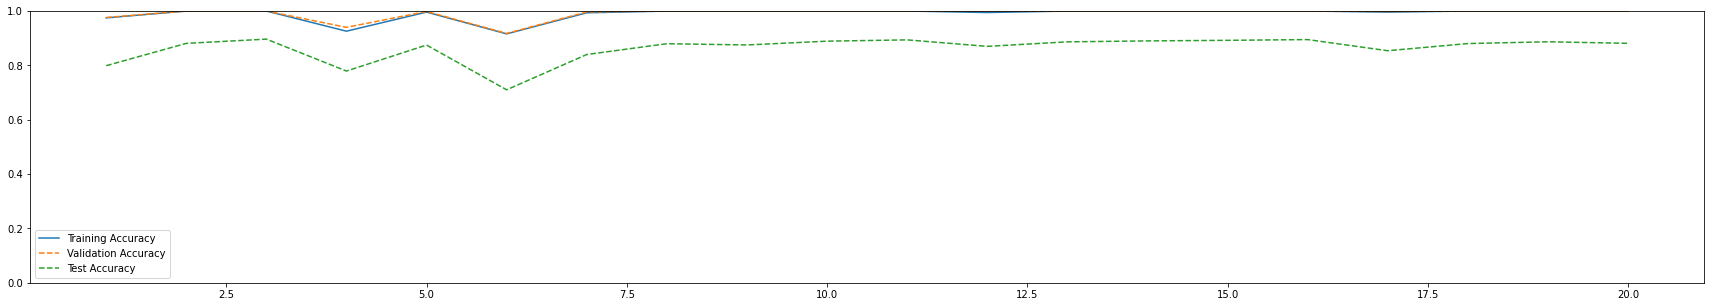

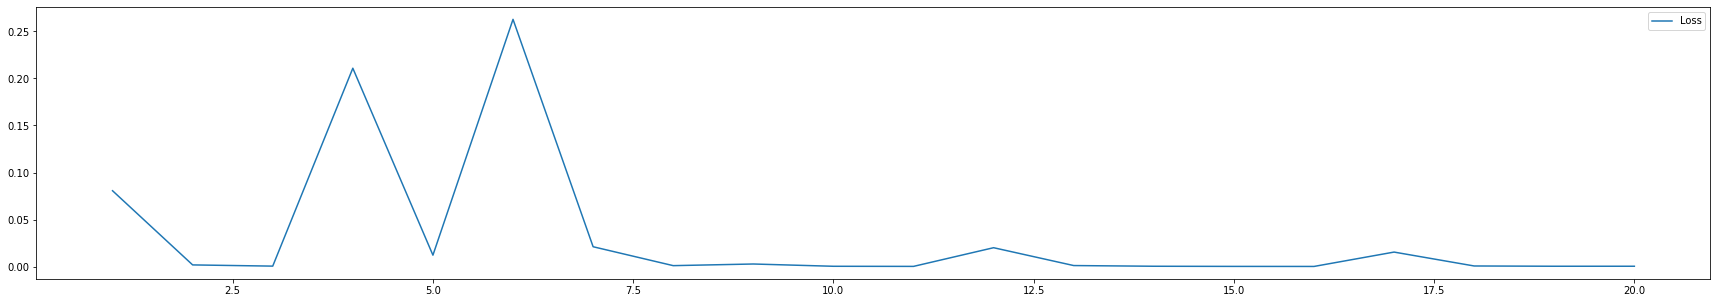

In [40]:
# print_confusion_matrix()
num_epochs = 20
batch_size = 64
update_freq = 2
[accs_train, accs_validation, accs_test, loss] = optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation, update_freq = update_freq)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_validation, '--', label='Validation Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_test, '--', label='Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), loss, label='Loss')
plt.legend()
plt.show()

# print_confusion_matrix()

In [41]:
[Test_Accuracy, _] = calcAccuracy(feed_dict_test)
print(Test_Accuracy)

0.8810487


#### Exporting the model

In [42]:
saver = tf.train.Saver()
saver.save(session, '/content/drive/My Drive/Courses/DeepLearning/Sign_Detector_88pAcc')

'/content/drive/My Drive/Courses/DeepLearning/Sign_Detector_88pAcc'